# 从零开始的循环神经网络（RNN）

使用 8.3 定义的语料库模型，即取自科幻小说 The Time Machine 的语料库

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)


In [2]:
len(vocab.idx_to_token)

28

## 独热码（One-Hot encode）

In [3]:
F.one_hot(torch.tensor(1), 10)

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [4]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params


In [5]:
def init_rnn_state(batch_size, num_hiddens, device):
    '''
    初始化 RNN 的隐藏层
    '''
    # 使用元组以利于隐藏层为多层的情况
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [6]:
# Compute the hidden state

# inputs 为多组mini batches，每个mini batch包含batch size个独热码
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []

    # X 为mini batch，其形状为： batch大小 * 词汇表大小
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    
    return torch.cat(outputs, dim=0), (H,)

In [7]:
class RNNModelStratch:
    """
    A zero-kara RNN Model
    """
    def __init__(self, vocab_size, num_hiddens, device, 
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    
    def __call__(self, x: torch.Tensor, state: torch.Tensor):
        # 将输入的 x 转为独热码
        x = F.one_hot(x.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(x, state, self.params)
    
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

### 检查代码功能

In [8]:
x = torch.arange(10).reshape(2, 5)
F.one_hot(x.T, 28)

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [9]:
num_hiddens = 512
net = RNNModelStratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(x.shape[0], d2l.try_gpu())
y, new_state = net(x.to(d2l.try_gpu()), state)
y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

## 预测值

warm-up period: 在一开始，我们只更新隐藏层而不做预测，让隐藏层的初始值稍微优化一些。

In [13]:
vocab['a'], vocab['t'], vocab['<unk>']

(4, 3, 0)

In [24]:
device = d2l.try_gpu()
prefix = 'time traveller '
num_preds = 10

state = net.begin_state(batch_size=1, device=device)
outputs = [vocab[prefix[0]]] # 返回第一个字母 't' 对应的 ID
# get_input 函数会返回序列的最后一位
get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(1, 1)
for y in prefix[1:]:
    _, state = net(get_input(), state)
    outputs.append(vocab[y])
for _ in range(num_preds):
    y, state = net(get_input(), state)
    outputs.append(int(y.argmax(dim=1).reshape(1)))
print(outputs, '\n', ''.join([vocab.idx_to_token[i] for i in outputs]))


[3, 5, 13, 2, 1, 3, 10, 4, 22, 2, 12, 12, 2, 10, 1, 27, 11, 2, 25, 9, 18, 15, 24, 23, 3] 
 time traveller qdezhgcxkt


In [25]:
get_input()

tensor([[3]], device='cuda:0')

In [26]:
y

tensor([[ 0.0005,  0.0017, -0.0004,  0.0065, -0.0022, -0.0008, -0.0028,  0.0016,
          0.0014,  0.0002, -0.0020,  0.0052,  0.0001, -0.0009,  0.0014, -0.0009,
         -0.0037,  0.0010,  0.0005,  0.0025, -0.0011,  0.0017,  0.0038, -0.0002,
          0.0008,  0.0003,  0.0027,  0.0016]], device='cuda:0',
       grad_fn=<CatBackward0>)

因为网络未训练，上面的预测过程会生成随机序列

In [17]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

## 梯度裁剪

In [27]:
def grad_clipping(net, theta):  #@save
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm


## 开始训练

In [29]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()



In [30]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))


perplexity 1.0, 107462.9 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


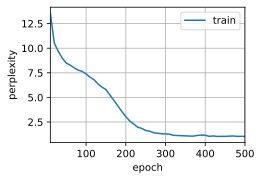

In [31]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())